# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for FCL1_W
Gradient check passed!
Checking gradient for FCL1_B
Gradient check passed!
Checking gradient for FCL2_W
Gradient check passed!
Checking gradient for FCL2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for FCL1_W
Gradient check passed!
Checking gradient for FCL1_B
Gradient check passed!
Checking gradient for FCL2_W
Gradient check passed!
Checking gradient for FCL2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.13333333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 2.302029, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, Loss: 2.301685, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, Loss: 2.301851, Train accuracy: 0.148222, val accuracy: 0.140000
Epoch: 3, Loss: 2.302623, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, Loss: 2.302031, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, Loss: 2.301124, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, Loss: 2.302831, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, Loss: 2.301638, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, Loss: 2.302170, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, Loss: 2.302117, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, Loss: 2.302455, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, Loss: 2.302807, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, Loss: 2.302832, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, Loss: 2.302

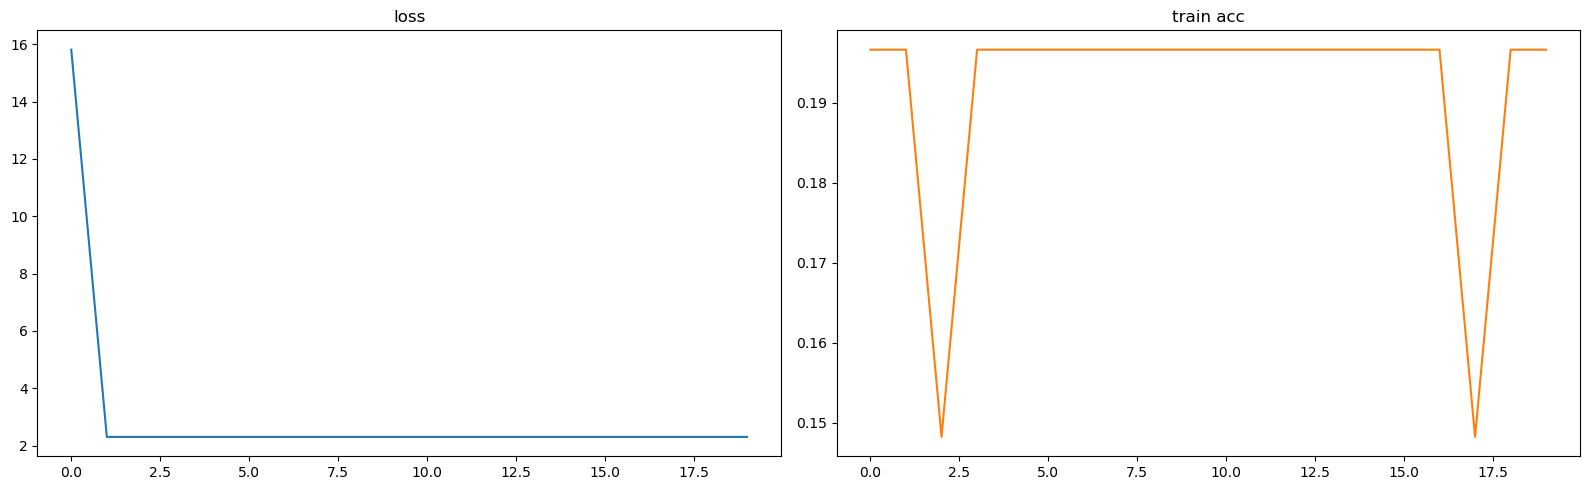

In [10]:
fig = plt.figure(figsize=(16,5), dpi=100)
history_dict = {"loss": loss_history, "train acc": train_history}
for i, history_key in enumerate(history_dict):
    plt.subplot(1, 2, i + 1)
    plt.title(history_key)
    plt.plot(history_dict[history_key], f'C{i}')
plt.tight_layout()

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch: 0, Loss: 5.910737, Train accuracy: 0.217444, val accuracy: 0.220000
Epoch: 1, Loss: 3.003226, Train accuracy: 0.197889, val accuracy: 0.206000
Epoch: 2, Loss: 2.374174, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, Loss: 2.319240, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, Loss: 2.246380, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, Loss: 2.268906, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, Loss: 2.201405, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, Loss: 2.325597, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, Loss: 2.301117, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, Loss: 2.311846, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, Loss: 2.233758, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, Loss: 2.283164, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, Loss: 2.354520, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, Loss: 2.217

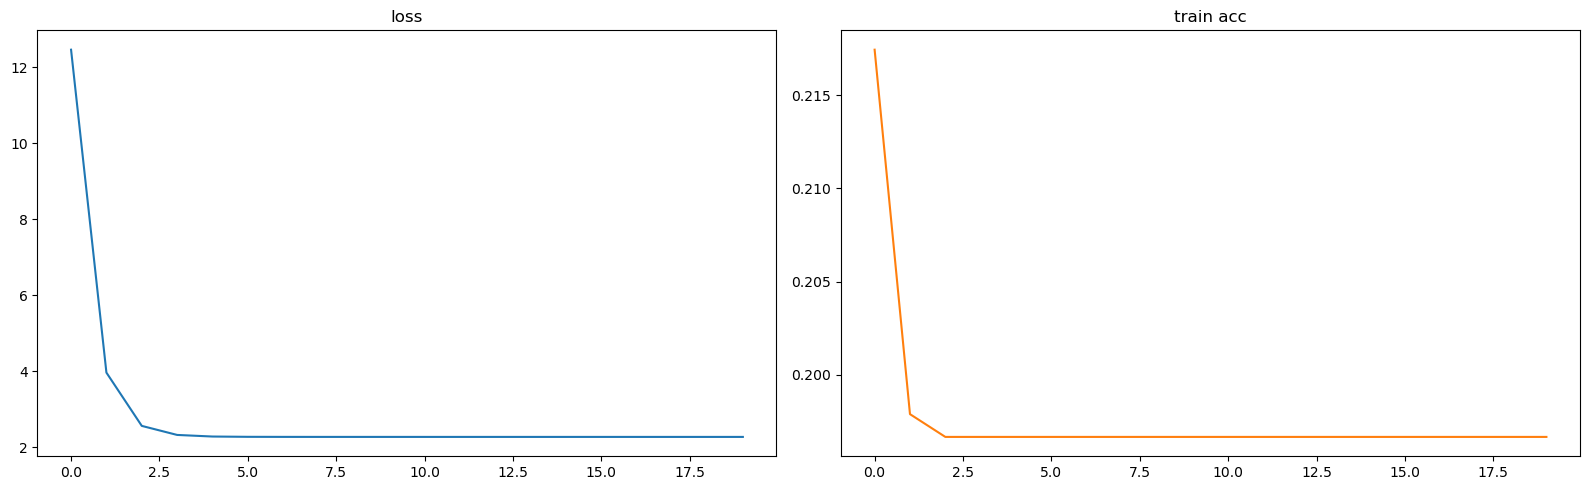

In [12]:
fig = plt.figure(figsize=(16,5), dpi=100)
history_dict = {"loss": loss_history, "train acc": train_history}
for i, history_key in enumerate(history_dict):
    plt.subplot(1, 2, i + 1)
    plt.title(history_key)
    plt.plot(history_dict[history_key], f'C{i}')
plt.tight_layout()

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 20.850786, Train accuracy: 0.178444, val accuracy: 0.195000
Epoch: 1, Loss: 17.709456, Train accuracy: 0.206556, val accuracy: 0.219000
Epoch: 2, Loss: 15.280282, Train accuracy: 0.217556, val accuracy: 0.220000
Epoch: 3, Loss: 13.000928, Train accuracy: 0.220333, val accuracy: 0.220000
Epoch: 4, Loss: 11.301719, Train accuracy: 0.222778, val accuracy: 0.218000
Epoch: 5, Loss: 10.075157, Train accuracy: 0.222000, val accuracy: 0.220000
Epoch: 6, Loss: 8.714871, Train accuracy: 0.221889, val accuracy: 0.219000
Epoch: 7, Loss: 7.698361, Train accuracy: 0.218889, val accuracy: 0.219000
Epoch: 8, Loss: 6.881611, Train accuracy: 0.216444, val accuracy: 0.219000
Epoch: 9, Loss: 6.197381, Train accuracy: 0.213222, val accuracy: 0.217000
Epoch: 10, Loss: 5.625639, Train accuracy: 0.211667, val accuracy: 0.215000
Epoch: 11, Loss: 5.182880, Train accuracy: 0.209333, val accuracy: 0.216000
Epoch: 12, Loss: 4.630010, Train accuracy: 0.207000, val accuracy: 0.214000
Epoch: 13, Loss:

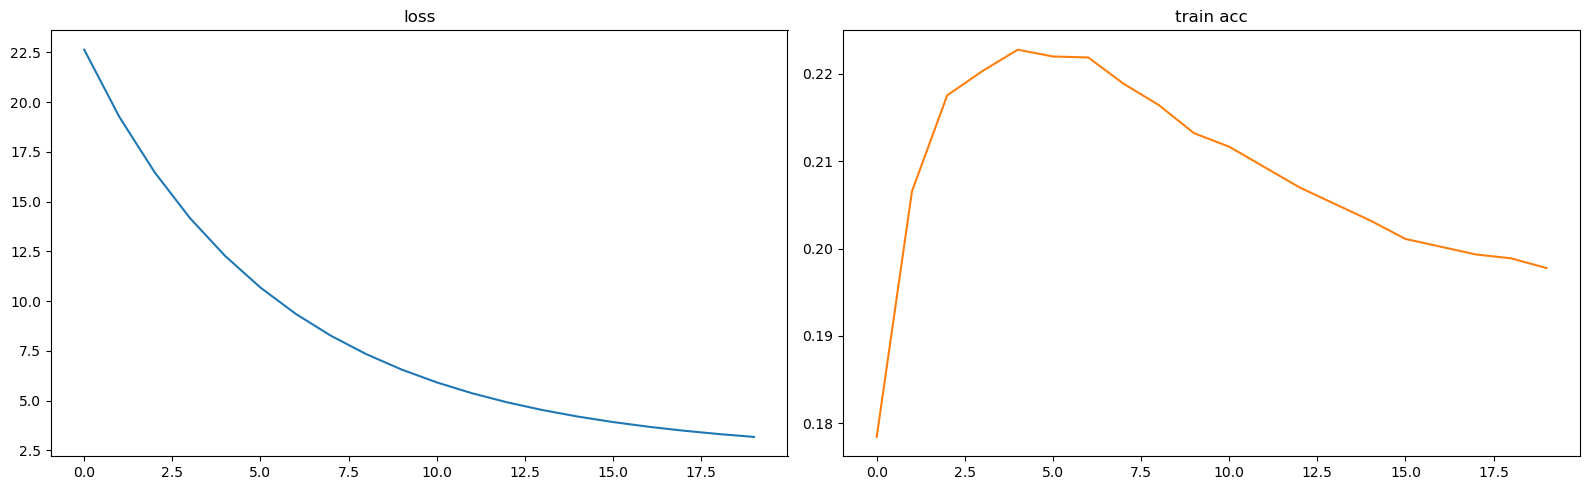

In [14]:
fig = plt.figure(figsize=(16,5), dpi=100)
history_dict = {"loss": loss_history, "train acc": train_history}
for i, history_key in enumerate(history_dict):
    plt.subplot(1, 2, i + 1)
    plt.title(history_key)
    plt.plot(history_dict[history_key], f'C{i}')
plt.tight_layout()

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [15]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 23.599342, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch: 1, Loss: 19.406759, Train accuracy: 0.733333, val accuracy: 0.000000
Epoch: 2, Loss: 17.591248, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 3, Loss: 15.304160, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 4, Loss: 13.464474, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 5, Loss: 12.247068, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 6, Loss: 11.096395, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 7, Loss: 9.811500, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 8, Loss: 8.618090, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 9, Loss: 7.846234, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 10, Loss: 7.140755, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 11, Loss: 6.382501, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 12, Loss: 5.949625, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 13, Loss

Epoch: 108, Loss: 1.259373, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 109, Loss: 1.245766, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 110, Loss: 1.404308, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 111, Loss: 1.247935, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 112, Loss: 1.209429, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 113, Loss: 1.302236, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 114, Loss: 1.330438, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 115, Loss: 1.389529, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 116, Loss: 1.415633, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 117, Loss: 1.315968, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 118, Loss: 1.422429, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 119, Loss: 1.476591, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 120, Loss: 1.280401, Train accuracy: 1.000000, val accuracy: 0.000000

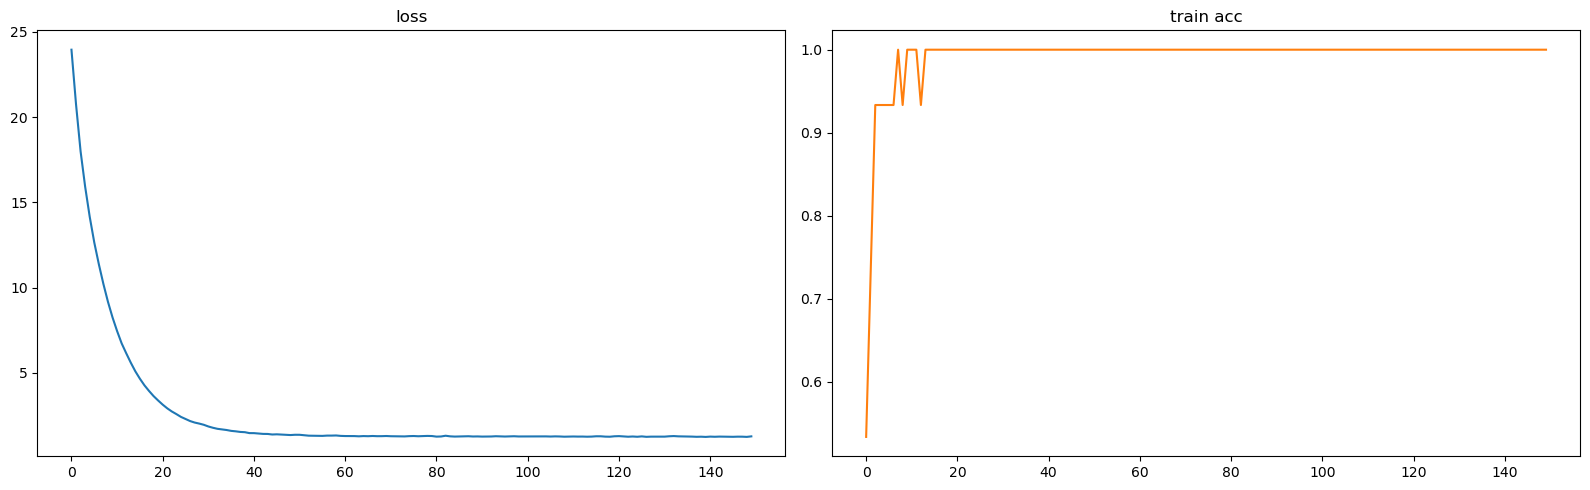

In [16]:
fig = plt.figure(figsize=(16,5), dpi=100)
history_dict = {"loss": loss_history, "train acc": train_history}
for i, history_key in enumerate(history_dict):
    plt.subplot(1, 2, i + 1)
    plt.title(history_key)
    plt.plot(history_dict[history_key], f'C{i}')
plt.tight_layout()

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [17]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less
data_size = 15

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), 
                  learning_rate=1e-2, 
                  learning_rate_decay=0.99, 
                  num_epochs=20, 
                  batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 2.553627, Train accuracy: 0.333333, val accuracy: 0.000000
Epoch: 1, Loss: 1.801347, Train accuracy: 0.666667, val accuracy: 0.000000
Epoch: 2, Loss: 1.398706, Train accuracy: 0.733333, val accuracy: 0.000000
Epoch: 3, Loss: 1.649558, Train accuracy: 0.800000, val accuracy: 0.000000
Epoch: 4, Loss: 1.430868, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 5, Loss: 0.824578, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 6, Loss: 0.627815, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 7, Loss: 0.702245, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 8, Loss: 0.595244, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 9, Loss: 0.662765, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 10, Loss: 0.436300, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 11, Loss: 0.491443, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 12, Loss: 0.319301, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 13, Loss: 0.330

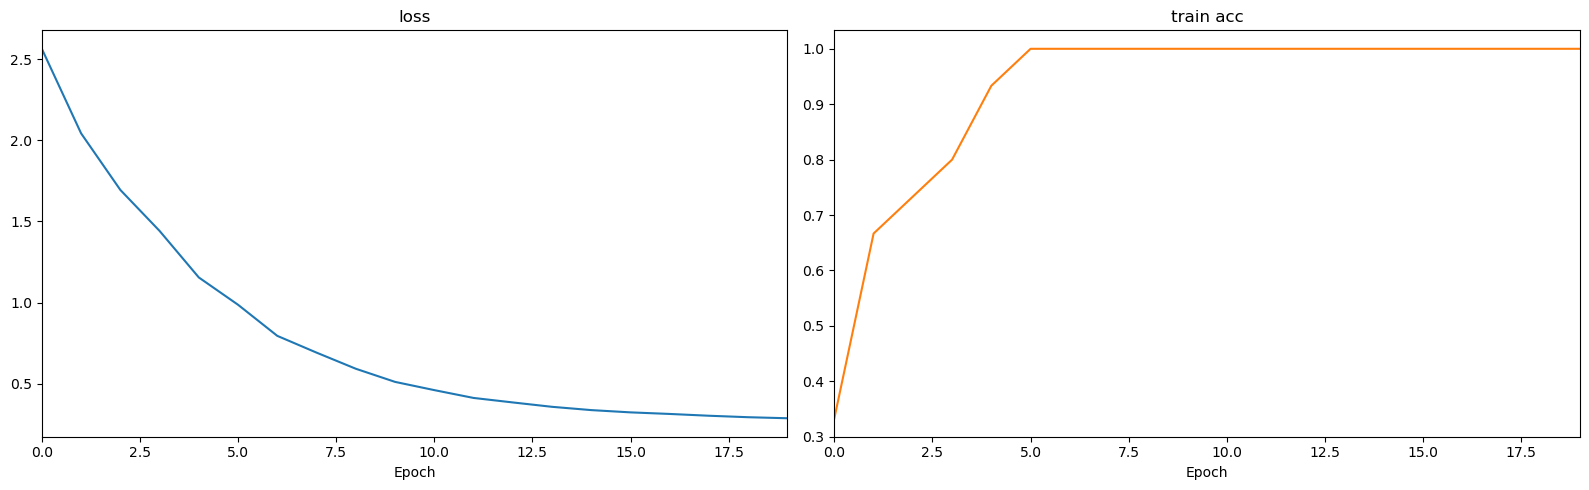

In [18]:
fig = plt.figure(figsize=(16,5), dpi=100)
history_dict = {"loss": loss_history, "train acc": train_history}
for i, history_key in enumerate(history_dict):
    plt.subplot(1, 2, i + 1)
    plt.title(history_key)
    plt.plot(history_dict[history_key], f'C{i}')
    plt.xlabel('Epoch')
    plt.xlim([0, 19])
plt.tight_layout()

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [19]:
learning_rates = [1e-1]
reg_strength = [1e-3]
learning_rate_decay = 0.99
hidden_layer_sizes = [625]
num_epochs = 150

batch_size = [450]

loss_history = []
train_history = []
val_history = []
best_params = []

best_model = None
best_val_accuracy = 0
dataset = Dataset(train_X, train_y, val_X, val_y)

In [20]:
for learning_rate in learning_rates:
    for reg_str in reg_strength:
        for hidden_layer_size in hidden_layer_sizes:
            for batch_sz in batch_size:
                model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, 
                                        hidden_layer_size = hidden_layer_size, 
                                        reg = reg_str)

                trainer = Trainer(model, dataset, MomentumSGD(), 
                                  num_epochs = num_epochs, 
                                  batch_size = batch_sz, 
                                  learning_rate = learning_rate, 
                                  learning_rate_decay = learning_rate_decay)

                loss_history, train_history, val_history = trainer.fit()
                max_val_acc = max(val_history)

                if (best_val_accuracy == 0 or max_val_acc > best_val_accuracy):
                    best_model = model
                    best_params = [learning_rate, reg_str, hidden_layer_size, batch_sz] 
                    print("new pretendent:", best_params)
                    best_val_accuracy = max_val_acc
            
print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch: 0, Loss: 3.238290, Train accuracy: 0.345667, val accuracy: 0.330000
Epoch: 1, Loss: 2.684494, Train accuracy: 0.539889, val accuracy: 0.510000
Epoch: 2, Loss: 2.342309, Train accuracy: 0.642444, val accuracy: 0.616000
Epoch: 3, Loss: 2.117443, Train accuracy: 0.673667, val accuracy: 0.650000
Epoch: 4, Loss: 2.020755, Train accuracy: 0.695667, val accuracy: 0.659000
Epoch: 5, Loss: 1.880796, Train accuracy: 0.734222, val accuracy: 0.681000
Epoch: 6, Loss: 1.787552, Train accuracy: 0.753333, val accuracy: 0.712000
Epoch: 7, Loss: 1.682699, Train accuracy: 0.749222, val accuracy: 0.702000
Epoch: 8, Loss: 1.643716, Train accuracy: 0.783556, val accuracy: 0.721000
Epoch: 9, Loss: 1.549986, Train accuracy: 0.799000, val accuracy: 0.743000
Epoch: 10, Loss: 1.470929, Train accuracy: 0.810889, val accuracy: 0.738000
Epoch: 11, Loss: 1.486733, Train accuracy: 0.807556, val accuracy: 0.741000
Epoch: 12, Loss: 1.448085, Train accuracy: 0.820444, val accuracy: 0.749000
Epoch: 13, Loss: 1.330

Epoch: 108, Loss: 0.635368, Train accuracy: 0.969111, val accuracy: 0.790000
Epoch: 109, Loss: 0.659088, Train accuracy: 0.964556, val accuracy: 0.784000
Epoch: 110, Loss: 0.670000, Train accuracy: 0.960778, val accuracy: 0.788000
Epoch: 111, Loss: 0.636462, Train accuracy: 0.961222, val accuracy: 0.777000
Epoch: 112, Loss: 0.644058, Train accuracy: 0.968000, val accuracy: 0.785000
Epoch: 113, Loss: 0.657141, Train accuracy: 0.968333, val accuracy: 0.789000
Epoch: 114, Loss: 0.640290, Train accuracy: 0.971111, val accuracy: 0.788000
Epoch: 115, Loss: 0.632762, Train accuracy: 0.969222, val accuracy: 0.795000
Epoch: 116, Loss: 0.694896, Train accuracy: 0.971444, val accuracy: 0.785000
Epoch: 117, Loss: 0.666090, Train accuracy: 0.969889, val accuracy: 0.790000
Epoch: 118, Loss: 0.678682, Train accuracy: 0.968889, val accuracy: 0.793000
Epoch: 119, Loss: 0.637803, Train accuracy: 0.971778, val accuracy: 0.789000
Epoch: 120, Loss: 0.665820, Train accuracy: 0.971333, val accuracy: 0.794000

[0.1, 0.001, 625, 450]


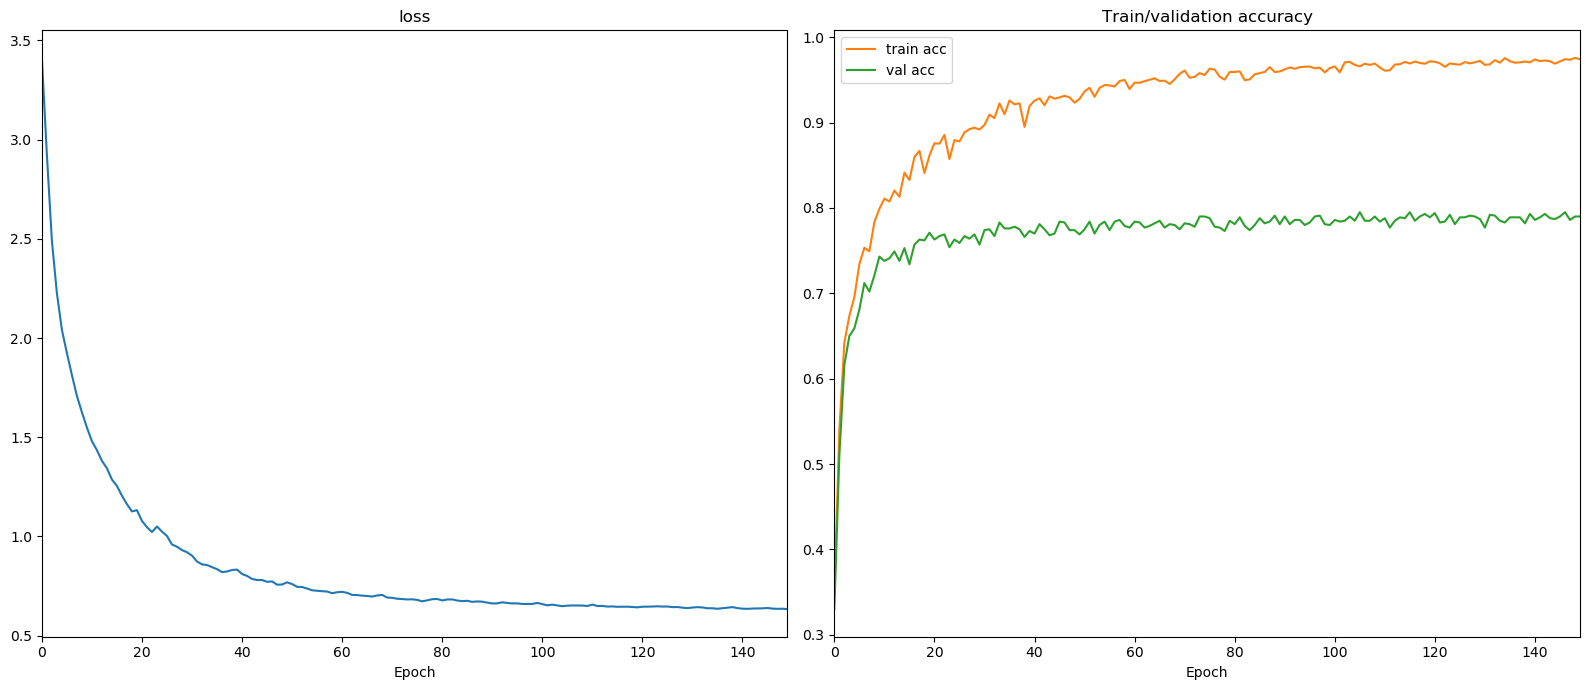

In [21]:
print(best_params)
fig = plt.figure(figsize=(16,7), dpi=100)
history_dict = {"loss": loss_history, "Train/validation accuracy": [train_history, val_history]}
for i, history_key in enumerate(history_dict):
    plt.subplot(1, 2, i + 1)
    plt.title(history_key)
    if history_key == "Train/validation accuracy":
        plt.plot(history_dict[history_key][0], f'C{i}', label='train acc')
        plt.plot(history_dict[history_key][1], f'C{i + 1}', label='val acc')
        plt.legend()
    else:
         plt.plot(history_dict[history_key], f'C{i}')
    plt.xlabel('Epoch')
    plt.xlim([0, num_epochs - 1])
plt.tight_layout()

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [23]:
test_pred = best_model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.776000
